# Requests

- do not simulate the individual requests, but choose a small enough time period (tick), in which a cache shows static behaviour, and describe its ingress/egress statistically

Minimal implementation: `BaseRequests`, working with the content id and the number of requests.

In [1]:
import pandas as pd

from cdnsim.requests import BaseRequests

# Create 1400 requests on 6 different contents (c1..c6)
r1 = BaseRequests(data={'freq': [300, 200, 100, 400, 200, 200]},
                  index=pd.MultiIndex.from_arrays([['c1', 'c2', 'c3', 'c4', 'c5', 'c6']], names=['content']))
r1

,freq
content,
c1,300
c2,200
c3,100
c4,400
c5,200
c6,200


<Axes: xlabel='content'>

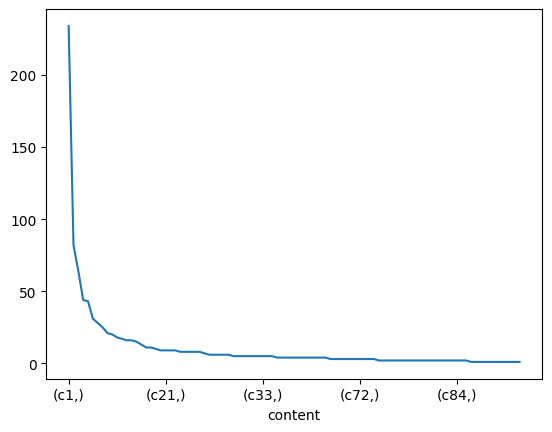

In [2]:
from scipy.stats import zipfian
import numpy as np

# create 1000 Zipf distributed requests with 1.1 shape parameter on 100 contents
zipf = np.unique(zipfian.rvs(1.1, 100, size=1000), return_counts=True)
r2 = BaseRequests(data={'freq': zipf[1]},
                  index=pd.MultiIndex.from_arrays([map(lambda x: f"c{x}", zipf[0])], names=['content']))
pd.Series(r2['freq'].sort_values(ascending=False)).plot()

## Methods

`BaseRequest` is a inherited from `pd.DataFrame`, so you can use all of its method natively. 

In [15]:
# number of requests on all content
r1.freq.sum()

np.int64(1400)

In [16]:
# contents, which have more than 250 requests
r1[r1.freq > 250].index.values

array([('c1',), ('c4',)], dtype=object)

## Merge

It is common in cache systems, that multiple users (or request profiles) are sent towards the same cache. Therefore, we need a method to combine these requests on a cache. This can be achieved by the `merge_requests()` method.

<Axes: xlabel='content'>

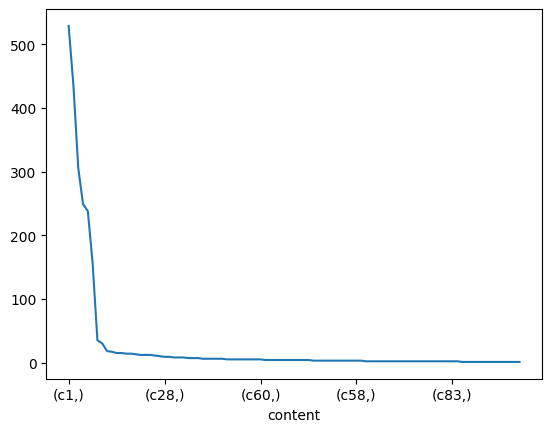

In [17]:
# merge (combine) r1 and r2
rm = BaseRequests.merge_requests([r1, r2])
pd.Series(rm['freq'].sort_values(ascending=False)).plot()

## Split round-robin

As with merge, caches may sent requests towards multiple systems, so splitting a request profile is also necessary. Here we implemented a round-robin fashion split.

In [18]:
rs = r1.split_rr(2)
rs

[         freq
 content      
 c1        150
 c2        100
 c3         50
 c4        200
 c5        100
 c6        100,
          freq
 content      
 c1        150
 c2        100
 c3         50
 c4        200
 c5        100
 c6        100]

## Extending requests

For throughput calculations, the tick (time) of the request and size of the content is needed. Let us extend `BaseRequests` to reflect on throughput. 

In [19]:
from typing import List
from typing import Self

import pandas as pd

from cdnsim.requests import BaseRequests


class ThroughputRequests(BaseRequests):

    @classmethod
    def merge_requests(cls, dfs: List[Self]) -> Self:
        """
        
        """
        if len(dfs) == 0:
            raise ValueError("Cannot merge an empty DataFrame")

        return ThroughputRequests(pd.DataFrame(pd.concat(dfs)).groupby(['tick', 'content']).agg(
            freq=pd.NamedAgg(column="freq", aggfunc="sum"),
            size=pd.NamedAgg(column="size", aggfunc="min")
        ))

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if 'tick' not in self.index.names:
            raise SyntaxError(f"'tick' must be part of the index names, got: {self.index.names}")
        if 'size' not in self.columns:
            raise SyntaxError(f"'size' must be part of the columns, got: {self.columns}")

    @property
    def rpt(self) -> pd.Series:
        return self.freq.groupby('tick').sum()

    @property
    def bpt(self) -> pd.Series:
        return self.prod(axis=1).groupby('tick').sum()


In [20]:
 # 4 contents (c1:10B, c2:20B, c3:30B, c4:4B), requests over 3 ticks: ca. 100,200,300 requests for each content
r = ThroughputRequests(freqs=[130, 90, 90, 100, 250, 230, 220, 240, 290, 330, 320, 330],
                       index={'tick': [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2],
                              'content': ['c1', 'c2', 'c3', 'c4', 'c1', 'c2', 'c3', 'c4', 'c1', 'c2', 'c3', 'c4'],
                              'size': [10, 20, 30, 4, 10, 20, 30, 4, 10, 20, 30, 4]})
r

TypeError: DataFrame.__init__() got an unexpected keyword argument 'freqs'

<Axes: xlabel='tick', ylabel='rpt'>

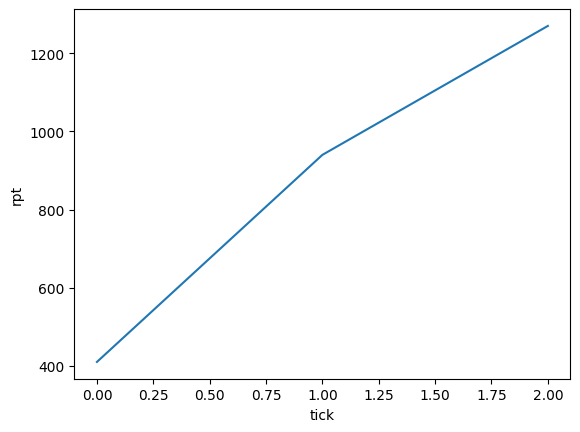

In [11]:
# requests pro tick (rpt)
r.rpt.plot.line(ylabel='rpt')

<Axes: xlabel='tick', ylabel='bpt'>

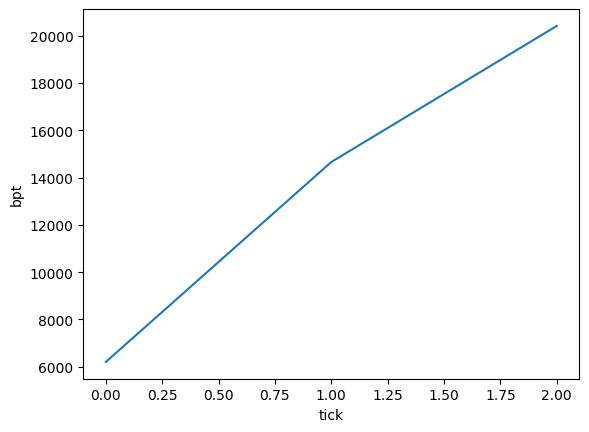

In [12]:
# bytes pro tick (bpt)
r.bpt.plot.line(ylabel='bpt')